In [197]:
import numpy as np
import pandas as pd
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm

# 1. set path
model_dir = '../models'
feature_dir = '../2025_A2/train/Features'
metadata_path = '../2025_A2/train/train_metadata.csv'
image_dir = '../2025_A2/train'


In [198]:

# 2. prepare train and validation set
color_df = pd.read_csv(os.path.join(feature_dir, 'color_histogram.csv'))
hog_df = pd.read_csv(os.path.join(feature_dir, 'hog_pca.csv'))
additional_df = pd.read_csv(os.path.join(feature_dir, 'additional_features.csv'))

def merge(meta):
    return (meta
            .merge(additional_df,  on="image_path")
            .merge(color_df, on="image_path")
            .merge(hog_df,    on="image_path"))

metadata_df = pd.read_csv(metadata_path)

X = merge(metadata_df)
y = metadata_df['ClassId']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

image_paths_val = X_val['image_path'].values
X_val = X_val.drop(columns=["ClassId", "image_path"])


In [199]:
print(X.shape)

(5488, 123)


In [200]:

# 3. load basic models
rf_model = joblib.load(os.path.join(model_dir, 'random_forest.pkl'))
nn_model = load_model(os.path.join(model_dir, 'neural_model.h5'))
cnn_model = load_model(os.path.join(model_dir, 'cnn_model.h5'))


In [201]:
# 4. prepare CNN input

cnn_val_images = []
for fname in image_paths_val:
    img = load_img(os.path.join(image_dir, fname), target_size=(64, 64))
    img_array = img_to_array(img) / 255.0
    cnn_val_images.append(img_array)
cnn_val_images = np.array(cnn_val_images)


In [202]:
# 5. every models make predictions
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_val)

proba_rf = rf_model.predict_proba(X_val)
proba_nn = nn_model.predict(X_scaled)
proba_cnn = cnn_model.predict(cnn_val_images)


35/35 [==============================] - 1s 15ms/step


In [203]:
# 6. train LogisticRegression
X_meta = np.concatenate([proba_rf, proba_nn, proba_cnn], axis=1)
y_meta = y_val

meta_learner = LogisticRegression(max_iter=1000)
meta_learner.fit(X_meta, y_meta)

y_pred = meta_learner.predict(X_meta)
acc = accuracy_score(y_meta, y_pred)
print(f"Stacking Validation Accuracy: {acc:.4f}")


✅ Stacking Validation Accuracy: 0.9654


In [204]:
# 7. kaggle predictions
feature_dir_test = '../2025_A2/test/Features'
meta_path_test = '../2025_A2/test/test_metadata.csv'

color_df_test = pd.read_csv(f"{feature_dir_test}/color_histogram.csv")
hog_df_test = pd.read_csv(f"{feature_dir_test}/hog_pca.csv")
additional_df_test = pd.read_csv(f"{feature_dir_test}/additional_features.csv")
def merge(meta):
    return (meta
            .merge(additional_df_test,  on="image_path")
            .merge(color_df_test, on="image_path")
            .merge(hog_df_test,    on="image_path"))

metadata_df_test = pd.read_csv(meta_path_test)

X_test = merge(metadata_df_test).drop(columns=["ClassId", "image_path"])
proba_rf_test = rf_model.predict_proba(X_test)

X_scaled_test = scaler.fit_transform(X_test)
proba_nn_test = nn_model.predict(X_scaled_test)

image_dir_test = '../2025_A2/test'

image_paths_val_test = pd.read_csv(meta_path_test)['image_path']
cnn_val_images_test = []
for fname in image_paths_val_test:
    img = load_img(os.path.join(image_dir_test, fname), target_size=(64, 64))
    img_array = img_to_array(img) / 255.0
    cnn_val_images_test.append(img_array)
cnn_val_images_test = np.array(cnn_val_images_test)
proba_cnn_test = cnn_model.predict(cnn_val_images_test)


X_meta_test = np.concatenate([proba_rf_test, proba_nn_test, proba_cnn_test], axis=1)
y_pred_test = meta_learner.predict(X_meta_test)
test_ids = pd.read_csv(meta_path_test)['id']
submission = pd.DataFrame({
    'id': test_ids,
    'ClassId': y_pred_test
})
submission.to_csv('../stacking_model_result.csv', index=False)

74/74 [==============================] - 1s 18ms/step


Stacking Accuracy : 0.9653916211293261
Balanced Accuracy: 0.9574598756435977

Classification Report:

              precision    recall  f1-score   support

           0      1.000     0.778     0.875         9
           1      0.926     0.862     0.893        58
           2      0.919     0.934     0.927        61
           3      0.919     0.919     0.919        37
           4      0.931     1.000     0.964        54
           5      0.961     0.942     0.951        52
           6      1.000     1.000     1.000        11
           7      1.000     0.905     0.950        42
           8      0.848     0.966     0.903        29
           9      0.976     1.000     0.988        41
          10      0.982     1.000     0.991        54
          11      0.973     0.973     0.973        37
          12      1.000     1.000     1.000        55
          13      0.984     1.000     0.992        60
          14      0.960     1.000     0.980        24
          15      1.000     1.000

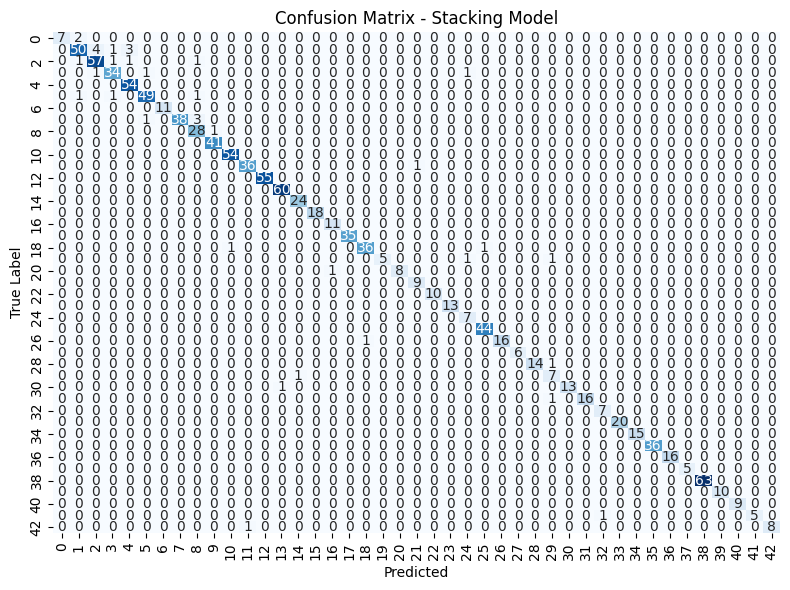

Macro-average ROC-AUC: 0.9998647397734098


In [205]:
# 8. evaluations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    classification_report, confusion_matrix, roc_auc_score
)
from sklearn.preprocessing import label_binarize
from tensorflow.keras.utils import to_categorical

# 1. Accuracy metrics
print("Stacking Accuracy :", accuracy_score(y_meta, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_meta, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_meta, y_pred, digits=3))

# 2. Confusion Matrix
cm = confusion_matrix(y_meta, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Stacking Model")
plt.tight_layout()
plt.show()

# 3. Macro-average ROC-AUC
try:
    y_true_bin = to_categorical(y_meta, num_classes=np.max(y_meta) + 1)
    y_prob = meta_learner.predict_proba(X_meta)
    roc_auc = roc_auc_score(y_true_bin, y_prob, average="macro", multi_class="ovr")
    print("Macro-average ROC-AUC:", roc_auc)
except Exception as e:
    print("ROC-AUC skipped:", e)
